In [1]:
import numpy as np
import pandas as pd
import random
import math

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date, timedelta

import yfinance as yf
# import yfinance.shared as shared

from pathlib import Path

In [2]:
def convert(x: str) -> float:
    if x.endswith("M"):
        x = float(x.strip("M"))
    elif x.endswith("B"):
        x = float(x.strip("B")) * 1000
    else:
        x = float(x)
    
    return x

def roundup_hundred(x: float) -> int:
    return int(math.ceil(x / 100)) * 100

In [3]:
# ipo_calendar 파일 불러오기
# IPOValue 컬럼이 null일 경우 우선 0으로 채움

ipo_calendar_path = "./ipo_calendar.csv"
ipo_calendar = pd.read_csv(ipo_calendar_path)
ipo_calendar["IPOValue"] = ipo_calendar["IPOValue"].fillna("0")
ipo_calendar.head()

,IPODate,CompanyName,StockCode,IPOValue,IPOPrice
0,2019-01-31,New Fortress Energy LLC,NFE,300.0M,15
1,2019-01-31,Pivotal Acquisition Corp,PVT_u,200.0M,10
2,2019-02-28,Super League Gaming Inc,SLGG,27.3M,10.00-12.00
3,2019-02-28,Tortoise Acquisition,SHLL_u,225.0M,10
4,2019-02-27,Kaleido Biosciences Inc,KLDO,104.8M,20.00-22.00


In [4]:
# 사용하기 쉽게 상장 연도/상장 밸류 (100M 단위)/종목 코드만 선택

ipo_calendar["Year"] = [date.fromisoformat(x).year for x in ipo_calendar["IPODate"]]
ipo_calendar["IPOValue"] = ipo_calendar["IPOValue"].apply(convert)
ipo_calendar["ValueGroup"] = ipo_calendar["IPOValue"].apply(roundup_hundred)
ipo_codes = ipo_calendar[["Year", "ValueGroup", "StockCode"]]
ipo_codes.head()

,Year,ValueGroup,StockCode
0,2019,300,NFE
1,2019,200,PVT_u
2,2019,100,SLGG
3,2019,300,SHLL_u
4,2019,200,KLDO


In [5]:
# 미사용 종목 코드 제거 (_u로 끝나는 경우)

ipo_codes = ipo_codes[ipo_codes["StockCode"].str.endswith("_u") == False]

### 샘플링 필요할 경우 아래 코드 실행 ###
# sample_codes = ipo_codes.groupby("Year", group_keys=False).apply(lambda x: x.sample(frac=0.25))
# sample_codes.groupby("Year").agg("count")

In [6]:
# yf에서 데이터 다운로드 및 상장 이후 1개월 단위 수익률 계산 ((N개월 후 종가 / 상장가) - 1 * 100)

result = {}

for ticker in ipo_codes["StockCode"].values:

    try:
        # Failed Download 메시지 안 나오게 수정 필요
        start_date = ipo_calendar[ipo_calendar["StockCode"] == ticker]["IPODate"].values[0]
        end_date = '2023-06-30' # fixed
    
        checker = date.fromisoformat(end_date) - date.fromisoformat(start_date)
    
        if checker.days >= 30:
        
            df = yf.download(ticker, start=start_date, end=end_date, progress=False)
            # print(list(shared._ERRORS.keys()))
            date_range = pd.date_range(start_date, end_date)
            df = df.reindex(date_range, fill_value=np.nan)
            df = df.fillna(method="ffill")

            month_range = pd.date_range(start_date, end_date, freq="30D")
            init_val = df[df.index == start_date]["Adj Close"].values[0]

            ror_list = []
            for d in month_range[1:]:
                val_ = df[df.index == d]["Adj Close"].values[0]
                ror = (val_ / init_val - 1) * 100
                ror_list.append(ror)

            result[ticker] = ror_list
        
    except:
        pass


1 Failed download:
['SOLY']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['MITO']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['ANCN']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['BFL']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2019-02-11 -> 2023-06-30)')

1 Failed download:
['IMAC']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['MNCLU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['HHHH']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['GMHIU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['INSUU']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed download:
['FHL']: Exception('%ticker%: No timezone found, symbol may be delisted')

1 Failed downloa

In [7]:
# 데이터 프레임 변환 및 컬럼명 변경

result_df = pd.DataFrame.from_dict(result, orient="index")
result_df = result_df.dropna(axis=0, how="all")
colnames = [f"{x+1}M" for x in result_df.columns]
result_df.columns = colnames

result_df.head()

,1M,2M,3M,4M,5M,6M,7M,8M,9M,10M,...,44M,45M,46M,47M,48M,49M,50M,51M,52M,53M
NFE,21.729140,-14.843163,-2.524872,-16.755948,-10.405514,-5.814835,22.800299,34.659534,31.063511,14.690133,...,333.425402,242.425690,296.947075,246.522228,227.720188,232.457471,167.319520,150.602789,159.176951,148.013575
SLGG,-5.516435,-19.014088,-14.671366,0.352110,-9.154937,-40.023476,-46.596245,-58.920190,-74.178405,-69.718312,...,-92.241784,-93.075118,-93.286385,-95.504695,-91.384977,-93.544601,-94.354460,-93.661972,-93.427230,NaN
HOTH,-33.704572,-43.141852,-35.521688,-23.212192,-38.569754,-37.749121,-37.456038,-50.820633,-46.858149,-45.603751,...,-95.697538,-97.247362,-98.128957,-98.471278,-97.584994,-98.686987,-99.057444,-99.109027,-99.254396,-98.550997
TCRR,15.129401,7.498348,7.299273,-9.489047,-13.735897,1.194428,18.978107,3.583278,-1.924353,11.811551,...,-88.453882,-89.515593,-91.439947,-94.368281,-90.842734,-92.103516,-90.046450,-87.923025,-88.387525,-90.179164
GOSS,9.977698,-3.511712,4.459304,2.954285,12.764766,10.758084,13.600884,-8.249729,21.516157,37.458189,...,-24.191750,-28.260872,-49.052396,-88.684504,-88.963211,-87.681160,-94.643255,-94.537347,-92.084727,-91.973244


In [9]:
df_final = pd.merge(ipo_codes, result_df, how="inner", left_on="StockCode", right_on=result_df.index)
df_final.head()

,Year,ValueGroup,StockCode,1M,2M,3M,4M,5M,6M,7M,...,44M,45M,46M,47M,48M,49M,50M,51M,52M,53M
0,2019,300,NFE,21.729140,-14.843163,-2.524872,-16.755948,-10.405514,-5.814835,22.800299,...,333.425402,242.425690,296.947075,246.522228,227.720188,232.457471,167.319520,150.602789,159.176951,148.013575
1,2019,100,SLGG,-5.516435,-19.014088,-14.671366,0.352110,-9.154937,-40.023476,-46.596245,...,-92.241784,-93.075118,-93.286385,-95.504695,-91.384977,-93.544601,-94.354460,-93.661972,-93.427230,NaN
2,2019,0,HOTH,-33.704572,-43.141852,-35.521688,-23.212192,-38.569754,-37.749121,-37.456038,...,-95.697538,-97.247362,-98.128957,-98.471278,-97.584994,-98.686987,-99.057444,-99.109027,-99.254396,-98.550997
3,2019,100,TCRR,15.129401,7.498348,7.299273,-9.489047,-13.735897,1.194428,18.978107,...,-88.453882,-89.515593,-91.439947,-94.368281,-90.842734,-92.103516,-90.046450,-87.923025,-88.387525,-90.179164
4,2019,300,GOSS,9.977698,-3.511712,4.459304,2.954285,12.764766,10.758084,13.600884,...,-24.191750,-28.260872,-49.052396,-88.684504,-88.963211,-87.681160,-94.643255,-94.537347,-92.084727,-91.973244


In [10]:
# 상장 연도별 코호트 시각화

cohort_yr = df_final.groupby("Year").mean(numeric_only=True)
cohort_yr = cohort_yr.dropna(axis=1, how="all")
cohort_yr = cohort_yr.drop(["ValueGroup"], axis=1)
cohort_yr.head()

,1M,2M,3M,4M,5M,6M,7M,8M,9M,10M,...,44M,45M,46M,47M,48M,49M,50M,51M,52M,53M
Year,,,,,,,,,,,,,,,,,,,,,
2019,-0.288434,-0.287919,-4.064634,-4.465465,-2.342546,2.776726,3.453809,5.178147,3.307154,9.096755,...,10.23253,17.461603,14.612046,18.59166,10.634992,-6.584215,-12.037904,4.226203,43.205632,-47.6857
2020,3.381103,13.207675,25.787254,35.586276,30.127771,23.668370,24.628663,23.728640,25.366286,23.560950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021,0.023623,-1.705753,-7.911797,-13.135105,-16.198222,-20.645435,-21.502579,-24.938996,-27.672332,-29.518737,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022,-16.223515,-22.054330,-25.810570,-26.164159,-29.210260,-29.597895,-29.412357,-30.834189,-31.979657,-31.520139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023,-5.002184,-2.999423,7.484237,13.915540,63.007805,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: ylabel='Year'>

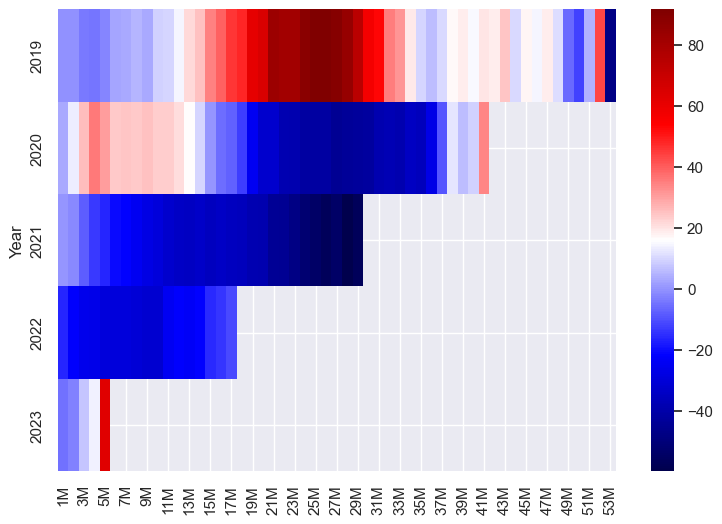

In [11]:
plt.figure(figsize=(9,6))
sns.set(rc={"figure.facecolor":"gray"})
sns.heatmap(cohort_yr, cmap="seismic")

가설 1: 상장 후 2년 뒤에 주식 수익률이 최대일 것이다.
* 2019: 약 1~2년 뒤 정점 찍고 상장 당시 수준 혹은 이하로 회귀, 2023년 주목 필요
* 2020: 향후 1년간 상승세 이후 하락, 역시 2023년 주목 필요
* 2021-22: 노답
* 2023: 상장 후 5~6개월차 주목 필요

> 1. 2020-21년이 불장이였다 정도일 것 같고, 세부적인 성장세는 종목별 + 시가총액별로 나눠보는게 더 유의미할 듯  
> 2. 수익률의 경우 평균으로 살펴봤기 때문에 평균의 오류가 있을 수도 있음은 감안해야 함

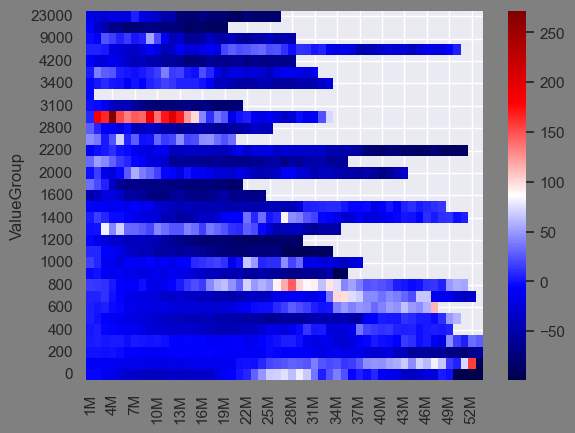

In [12]:
# 상장 밸류 그룹별 코호트 시각화

cohort_val = df_final.groupby("ValueGroup").mean(numeric_only=True)
cohort_val = cohort_val.dropna(axis=1, how="all")
cohort_val = cohort_val.drop(["Year"], axis=1)

ax = sns.heatmap(cohort_val, cmap="seismic")
ax.invert_yaxis()

가설 2: 상장 당시 시가총액과 이후 수익률은 정비례 할 것이다.
* 항상 그렇지만은 않음

> 1. 마찬가지로 평균의 오류를 감안해야 함  
> 2. 평균적으로 봤을 때 상장 이후로 수익을 보는 종목이 없다라고 봐야 하는 게 맞는 건가 싶음  
> 3. 시가총액/연도별 기준 외에 다른 기준을 살펴보는 게 유의미 할 듯 - 예를 들어, 종목의 섹터 등  
> 4. 이전에 의논한대로 종목별로 특성 발견 및 해당 특성에 맞는 매수+매도 타이밍을 찾는 방식으로 가야할 듯